# Model Training and Result Analysis

## Imports and Data Loading

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

# Model Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
df = pd.read_pickle('data/data_processed.pkl')

## Defining useful functions

In [3]:
def split(x, y, test_size = 0.2, log=False):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 0, stratify=y)

    if log:
        print("Train Shape:")
        print(X_train.shape, y_train.shape)
        print("Test Shape:")
        print(X_test.shape, y_test.shape)

        print("\nLabel distribution in the training set:")
        print(y_train.value_counts())
        print("\nLabel distribution in the test set:")
        print(y_test.value_counts())

    return X_train, X_test, y_train, y_test

In [4]:
def evaluate(y_test, y_pred):
    # confusion matrix
    print(confusion_matrix(y_test, y_pred))

    # accuracy, precision, recall, f1
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1:", f1_score(y_test, y_pred, average='weighted'))

In [5]:
def train(model, x, y, split_size = 0.2, cross_count = 0):
    if cross_count == 0:
        X_train, X_test, y_train, y_test = split(x, y, test_size = split_size)

        # Train and evaluate model
        model.fit(X_train, y_train) # maybe add a K-FOLDS here
        y_pred = model.predict(X_test)
        evaluate(y_test, y_pred)
    else:
        scores = cross_validate(model, x, y, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], return_train_score=True)
        print(scores)

In [6]:
def show_cm(cm, classes, figsize=(10, 10)):
    # cm = np.array([[TP, FP], [FN, TN]])
    plt.figure(figsize=figsize)
    plt.imshow(cm)
    plt.suptitle('Confusion matrix')
    total = sum(sum(cm))
    plt.title('Total cases: {}'.format(total))
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            perc = round(cm[i, j] / total * 100, 1)
            plt.text(j, i, f"{format(cm[i, j], '.0f')} : {perc}%", horizontalalignment="center",
                     color="black" if cm[i, j] > cm.max() / 2 else "white")

    plt.show()

## Defining the models to be trained

In [7]:
models = [
    lambda: MultinomialNB(), # Naive Bayes
    lambda: DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=15, weights='uniform'),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42),
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42), # Neural Network
    lambda: SVC(C=0.1, kernel='linear', probability=True), # Support Vector Machine
    lambda: LogisticRegression(penalty='l2'), # Linear Model with overfitting avoidance
    lambda: LinearSVC(penalty='l2'), # Linear Model with overfitting avoidance

    # Linear Model with stochastic gradient descent learning (loss function)
    lambda: SGDClassifier(loss='log', penalty='l2', alpha=0.001, max_iter=100, random_state=42)
]

# Model Training

In [8]:
# df = pd.read_pickle('data/reps/2_bow.pkl')
# df = pd.read_pickle('data/reps/5_embeddings_original.pkl')
df = pd.read_pickle('data/reps/6_embeddings_fasttext.pkl')
df = df.reset_index(drop=True)

df.head()

,text,emotions
0,"[0.03256098, 0.0119558135, 0.08880227, 0.13040...",anger
1,"[0.0076877284, -0.022412434, 0.007440353, 0.05...",anger
2,"[0.018128987, 0.040791623, 0.015959974, 0.0867...",anger
3,"[-0.008284954, -0.013932122, 0.03403318, 0.116...",anger
4,"[-0.006185096, -0.032958362, 0.018128073, 0.05...",anger


In [9]:
df_features = pd.DataFrame(df['text'].values.tolist())
df = pd.concat([df_features, df['emotions']], axis=1)

In [10]:
# Print the balance of the dataset
print(df['emotions'].value_counts())

emotions
joy         14107
sadness     12119
anger        5732
fear         4771
love         3455
surprise     1497
Name: count, dtype: int64


[[  52    1  609    0  505    0]
 [   5   12  561    0  354    0]
 [   0    2 2392    0  467    1]
 [   0    0  572    0  119    0]
 [   3    2 1115    0 1291    0]
 [   2    0  174    0   94    4]]
Accuracy: 0.44992203430490585
Precision: 0.5059492311179623
Recall: 0.44992203430490585
F1: 0.3563117651617581


/home/sparks/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


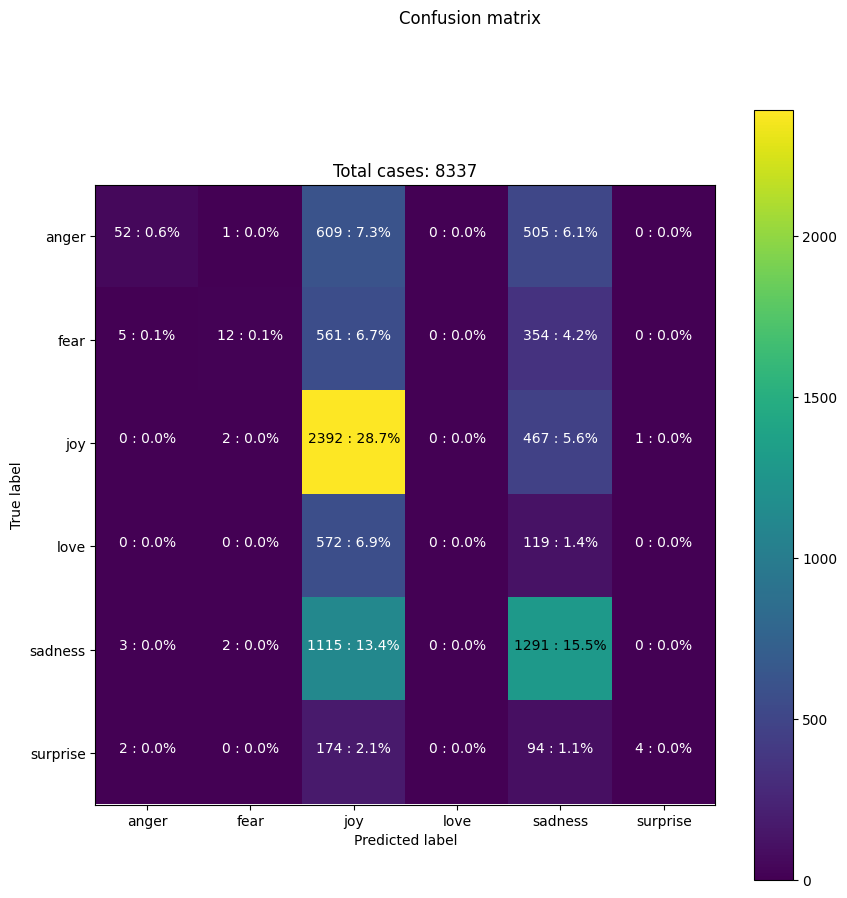

In [11]:
x = df.drop('emotions', axis=1).values
y = df['emotions']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# Initialize SVM model
# model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
model = models[4]()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
evaluate(y_test, y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Show confusion matrix
show_cm(cm, y.unique())

In [ ]:
""" # train all models 
for model in models:
    print(model)
    try:
        train(model(), df.drop('emotions', axis=1), df['emotions'], cross_count=5)
    except Exception as e:
        print(e)
    print("\n ---------------- \n") """